In [1]:
import math
import pandas as pd
import numpy as np
import scipy
import padasip as pa 
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline



# Reading data

In [2]:
train_df = pd.read_csv('data/TrainData2.csv', delimiter = ',').dropna().reset_index(drop=True)
train_df['TIMESTAMP'] = pd.to_datetime(train_df['TIMESTAMP'], format='%Y%m%d %H:%M')
train_df = train_df.set_index('TIMESTAMP')
std_dev = 3
train_df = train_df[(np.abs(stats.zscore(train_df)) < float(std_dev)).all(axis=1)]

In [3]:
pred_df = pd.read_csv('data/WeatherForecastInput2.csv', delimiter = ',')
pred_df['TIMESTAMP'] = pd.to_datetime(pred_df['TIMESTAMP'], format='%Y%m%d %H:%M')
pred_df = pred_df.set_index('TIMESTAMP')

In [4]:
result_st2 = pd.read_csv('data/Solution2.csv', delimiter = ',')
result_st2['TIMESTAMP'] = pd.to_datetime(result_st2['TIMESTAMP'], format='%Y%m%d %H:%M')
result_st2 = result_st2.set_index('TIMESTAMP')

# Feature Engineering

In [5]:
X = pd.DataFrame()
X['U10'] = train_df['U10']
X['U100'] = train_df['U100']
X['V10'] = train_df['V10']
X['V100'] = train_df['V100']
X['U10^2'] = X['U10']**2
X['U100^2'] = X['U100']**2
X['V10^2'] = X['V10']**2
X['V100^2'] = X['V100']**2
X['U10^3'] = X['U10']**3
X['U100^3'] = X['U100']**3
X['V10^3'] = X['V10']**3
X['V100^3'] = X['V100']**3

X['W10'] = np.sqrt(train_df['U10']**2 + train_df['V10']**2)
X['W100'] = np.sqrt(train_df['U100']**2 + train_df['V100']**2)
X['W10^2'] = X['W10']**2
X['W100^2'] = X['W100']**2
X['W10^3'] = X['W10']**3
X['W100^3'] = X['W100']**3
X['cosTheta10'] = train_df['U10']/X['W10']
X['sinTheta10'] = train_df['V10']/X['W10']
X['cosTheta100'] = train_df['U100']/X['W100']
X['sinTheta100'] = train_df['V100']/X['W100']

X['beta_0'] = 1

X['hour'] = X.index.hour
X['year'] = X.index.year
X['month'] = X.index.month

y = train_df[['POWER']].copy()

X_pred = pd.DataFrame()

X_pred['U10'] = pred_df['U10']
X_pred['U100'] = pred_df['U100']
X_pred['V10'] = pred_df['V10']
X_pred['V100'] = pred_df['V100']
X_pred['U10^2'] = X_pred['U10']**2
X_pred['U100^2'] = X_pred['U100']**2
X_pred['V10^2'] = X_pred['V10']**2
X_pred['V100^2'] = X_pred['V100']**2
X_pred['U10^3'] = X_pred['U10']**3
X_pred['U100^3'] = X_pred['U100']**3
X_pred['V10^3'] = X_pred['V10']**3
X_pred['V100^3'] = X_pred['V100']**3

X_pred['W10'] = np.sqrt(pred_df['U10']**2 + pred_df['V10']**2)
X_pred['W100'] = np.sqrt(pred_df['U100']**2 + pred_df['V100']**2)
X_pred['W10^2'] = X_pred['W10']**2
X_pred['W100^2'] = X_pred['W100']**2
X_pred['W10^3'] = X_pred['W10']**3
X_pred['W100^3'] = X_pred['W100']**3
X_pred['cosTheta10'] = pred_df['U10']/X_pred['W10']
X_pred['sinTheta10'] = pred_df['V10']/X_pred['W10']
X_pred['cosTheta100'] = pred_df['U100']/X_pred['W100']
X_pred['sinTheta100'] = pred_df['V100']/X_pred['W100']

X_pred['beta_0'] = 1

X_pred['hour'] = X_pred.index.hour
X_pred['year'] = X_pred.index.year
X_pred['month'] = X_pred.index.month


# Using complete data

In [ ]:
results = result_st2['POWER'].values.reshape(len(result_st2))

model_complete = LinearRegression()
model_complete.fit(X, y)
y_pred = model_complete.predict(X_pred).clip(min=0,max=1)
rmse = np.sqrt(mean_squared_error(y_pred,results))
#np.savetxt("stage2_complete.csv", y_pred, delimiter=",")

In [6]:
results = result_st2['POWER'].values.reshape(len(result_st2))


# Third stage

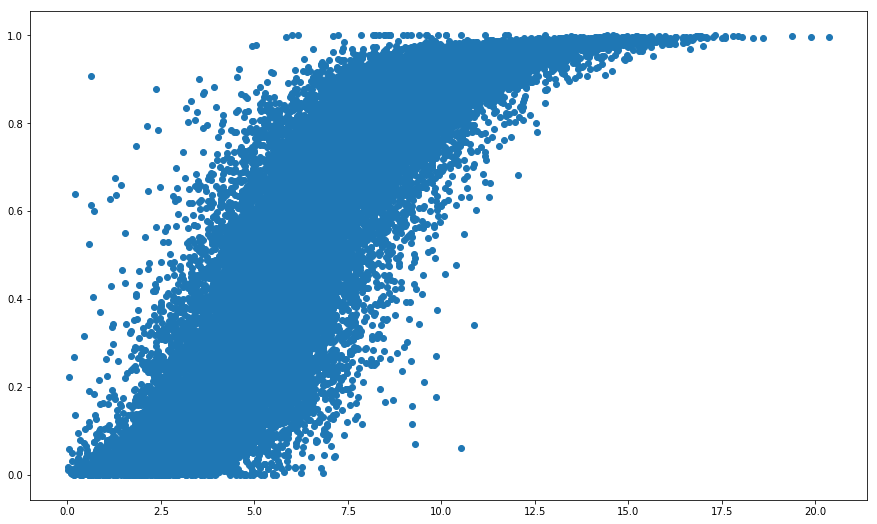

In [11]:
wind = X['W10']
power = y['POWER']

plt.figure(figsize=(15,9))
plt.scatter(wind,power)

In [7]:
data = X.join(y)
data_pred = X_pred

data_dict = {}
data_pred_dict = {}

models = {}

predictions = {}

timestamps = {}

dict_df = {}


N = 15

delta = 20/N

for i in range(N):
    data_dict.update({i : data[(data['W10'] >= (i*delta)) & (data['W10'] < ((i+1)*delta))]})
    data_pred_dict.update({i : data_pred[(data_pred['W10'] >= (i*delta)) & (data_pred['W10'] < ((i+1)*delta))]})
    X_aux = data_dict[i].values[:,:-1]
    y_aux = data_dict[i].values[:,-1]
    models.update({i : LinearRegression().fit(X_aux,y_aux)})
    
    X_pred_aux = data_pred_dict[i].values
    timestamps.update({i : data_pred_dict[i].index})

    if X_pred_aux.shape[0] != 0:
        predictions.update({i : models[i].predict(X_pred_aux)})
    else:
        predictions.update({i : []})
        
    df_pred = pd.DataFrame(predictions[i])
    df_time = pd.DataFrame(timestamps[i])
    
    dict_df.update({i : df_time.join(df_pred).set_index('TIMESTAMP')})

df = dict_df[0]
for i in range(N-1):
    df = pd.concat([df, dict_df[i+1]])

predictions = df.sort_index().values
rmse = np.sqrt(mean_squared_error(predictions,results))
rmse

0.14137041902694483

In [8]:
scores = []
#n = [2,5,7,10,12,15,20]
n = range(20)[1:]
for j in n:
    data = X.join(y)
    data_pred = X_pred

    data_dict = {}
    data_pred_dict = {}

    models = {}

    predictions = {}

    timestamps = {}

    dict_df = {}


    N = j

    delta = 20/N

    for i in range(N):
        data_dict.update({i : data[(data['W10'] >= (i*delta)) & (data['W10'] < ((i+1)*delta))]})
        data_pred_dict.update({i : data_pred[(data_pred['W10'] >= (i*delta)) & (data_pred['W10'] < ((i+1)*delta))]})
        X_aux = data_dict[i].values[:,:-1]
        y_aux = data_dict[i].values[:,-1]
        models.update({i : LinearRegression().fit(X_aux,y_aux)})

        X_pred_aux = data_pred_dict[i].values
        timestamps.update({i : data_pred_dict[i].index})

        if X_pred_aux.shape[0] != 0:
            predictions.update({i : models[i].predict(X_pred_aux)})
        else:
            predictions.update({i : []})

        df_pred = pd.DataFrame(predictions[i])
        df_time = pd.DataFrame(timestamps[i])

        dict_df.update({i : df_time.join(df_pred).set_index('TIMESTAMP')})

    df = dict_df[0]
    for i in range(N-1):
        df = pd.concat([df, dict_df[i+1]])

    predictions = df.sort_index().values
    rmse = np.sqrt(mean_squared_error(predictions,results))

    scores.append(rmse) 

In [9]:
scores

[0.14967839712682585,
 0.14664632754064408,
 0.14597354302687615,
 0.14407611287274394,
 0.14294517355036473,
 0.14125912775777374,
 0.14065000869436298,
 0.14268193633131293,
 0.14095353011689296,
 0.1412154142213253,
 0.14110881530746391,
 0.14033529098201275,
 0.14089150333801784,
 0.14058936207371686,
 0.14137041902694483,
 0.14098321122292523,
 0.1410903068733217,
 0.14093929456438625,
 0.14151361012486371]

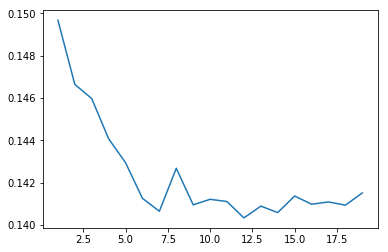

In [10]:
plt.plot(n,np.array(scores))